In [2]:
import os
import sys
import librosa
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.config.shared_configs import BaseDatasetConfig
from TTS.tts.datasets import load_tts_samples
from TTS.tts.datasets.formatters import *
%matplotlib inline

In [28]:
NUM_PROC = 1
DATASET_CONFIG = BaseDatasetConfig(
    meta_file_train="wavs_text_norm.txt", path="C:\\Users\\diego\\OneDrive - UNIVERSIDAD NACIONAL AUTÓNOMA DE MÉXICO\\Analisis"
)

In [4]:

import chardet


with open("wavs_text_norm.txt", "rb") as f:
  rawdata = f.read()


result = chardet.detect(rawdata)

print(f"Codificación del archivo: {result['encoding']}")


Codificación del archivo: utf-8


In [5]:
def formatter(root_path, meta_file, **kwargs):  # pylint: disable=unused-argument
    txt_file = os.path.join(root_path, meta_file)
    items = []
    speaker_name = "myspeaker"
    with open(txt_file, "r", encoding="utf-8") as ttf:
        for line in ttf:
            cols = line.split("|")
            wav_file = os.path.join(root_path, "wavs", cols[0])            
            text = cols[1]
            items.append({"text": text, "audio_file": wav_file, "speaker_name": speaker_name, "root_path": root_path})
    return items

In [6]:
train_samples, eval_samples = load_tts_samples(DATASET_CONFIG, eval_split=True, formatter=formatter)
if eval_samples is not None:
    #print("hola")
    items = train_samples + eval_samples
else:
    items = train_samples
print(" > Number of audio files: {}".format(len(items)))
print(items[33])

 > Number of audio files: 134
{'text': ' haciendo los tribunos en general a la clase de los ricos y habiendo siempre un gran número de plebeños entre estos, equilibraban el crédito de los patricios en esta primera clase. ', 'audio_file': 'C:\\Users\\diego\\OneDrive - UNIVERSIDAD NACIONAL AUTÓNOMA DE MÉXICO\\Analisis\\wavs\\Audio_segment_1072.wav  ', 'speaker_name': 'myspeaker', 'root_path': 'C:\\Users\\diego\\OneDrive - UNIVERSIDAD NACIONAL AUTÓNOMA DE MÉXICO\\Analisis', 'language': '', 'audio_unique_name': '#wavs\\Audio_segment_1072'}


In [7]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = item["audio_file"].strip()
    if os.path.exists(wav_file):  # Verifica si el archivo existe
        wav_files.append(wav_file)
    else:
        print(f"Warning: File does not exist: {wav_file}")

In [8]:
# show duplicate items
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


In [29]:
def load_item(item):
    text = item["text"].strip()
    file_name = item["audio_file"].strip()
    audio, sr = librosa.load(file_name, sr=None)
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(8) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

  0%|          | 0/134 [00:00<?, ?it/s]

In [10]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

100%|██████████| 134/134 [00:00<?, ?it/s]

 > Number of words: 1534


In [11]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

100%|██████████| 134/134 [00:00<?, ?it/s]


In [12]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

In [13]:
for item in data:
    if item[-1] < 2:
        print(item)

In [14]:
sec_per_chars = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)

In [15]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)

0.08384650324547804
0.01824762707341926


In [16]:
dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    pdf =norm.pdf(sec_per_char)
    if pdf < 0.39:
        print(item)

('C:\\Users\\diego\\OneDrive - UNIVERSIDAD NACIONAL AUTÓNOMA DE MÉXICO\\Analisis\\wavs\\Audio_segment_1094.wav', 'de la república de Venencia, cuyo simulacro existe aún un único.', 64, array([0.01922607, 0.01266479, 0.00866699, ..., 0.01200867, 0.01687622,
       0.02056885], dtype=float32), 15.0)


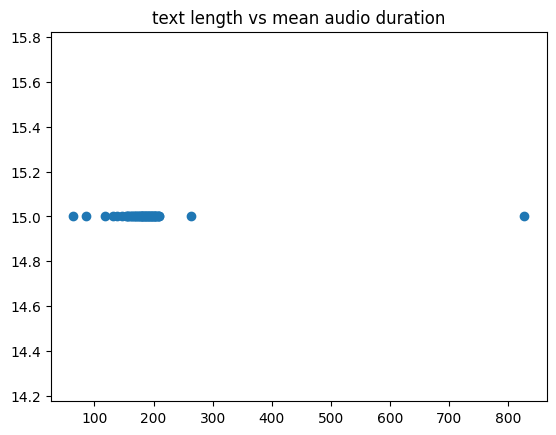

In [17]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

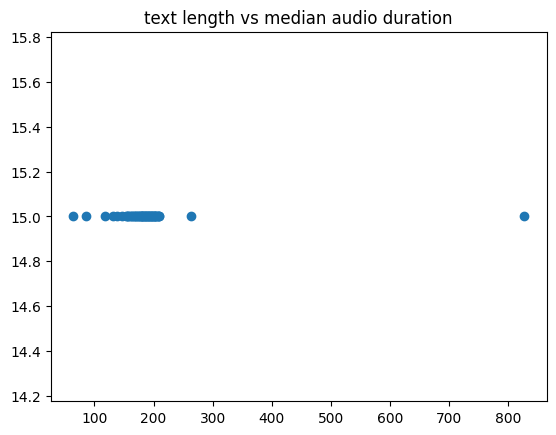

In [18]:
plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

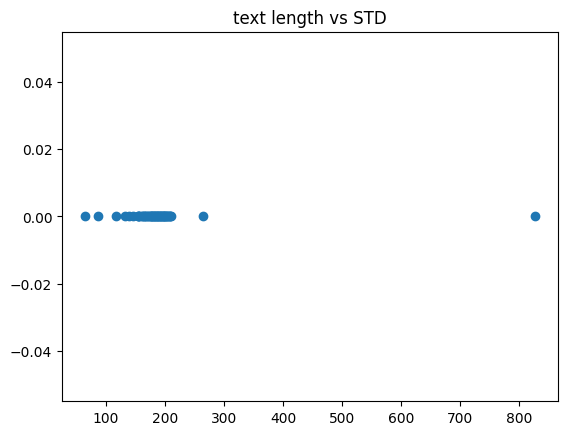

In [19]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

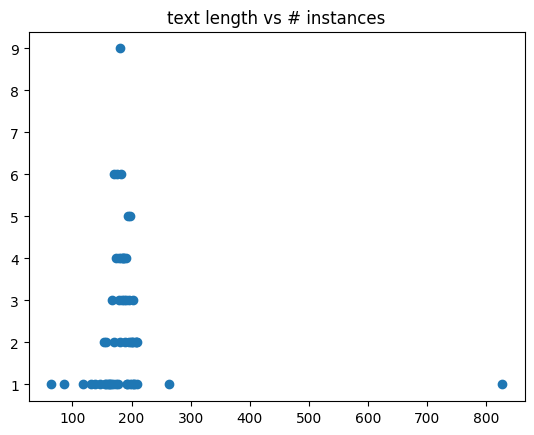

In [20]:
plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

In [21]:
w_count_df = pd.DataFrame.from_dict(w_count, orient='index')
w_count_df.sort_values(0, ascending=False, inplace=True)

In [22]:
w_count_df

,0
de,323
la,201
los,149
que,145
el,126
...,...
corgir,1
edictos.,1
tráfico,1
intrigas,1


In [26]:
# check a certain word
w_count_df.at['política', 0]

1

<Axes: >

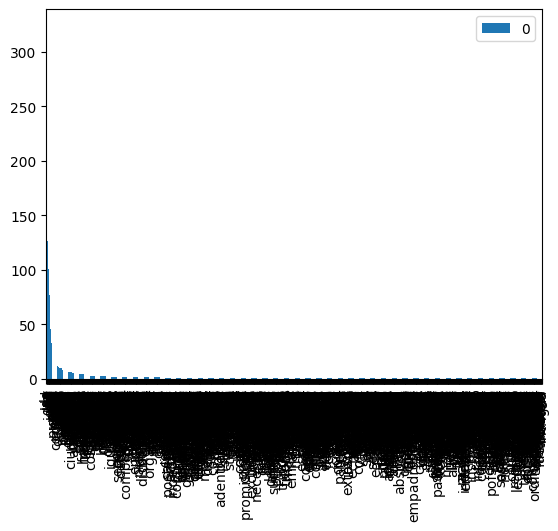

In [27]:
# fequency bar plot
w_count_df.plot.bar()